In [1]:
%%capture
!pip install datasets torch torchvision torchaudio transformers evaluate numpy rouge_score tensorboard

In [2]:
from datasets import load_dataset
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, Seq2SeqTrainer , Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, AutoConfig, EarlyStoppingCallback
import evaluate

In [3]:
import torch
import numpy
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
os.name

'posix'

In [5]:
size = 10000

In [6]:
# 1. Tải dataset
dataset = load_dataset("nhantruongcse/summary-vietnamese-news")
dataset

README.md:   0%|          | 0.00/321 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/161M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/164573 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Content', 'Summary'],
        num_rows: 164573
    })
})

In [7]:
train_size = int(size * 0.8)
train_dataset_raw = dataset['train'].select(range(train_size))
val_dataset_raw = dataset['train'].select(range(train_size, size))
type(train_dataset_raw), val_dataset_raw

(datasets.arrow_dataset.Dataset,
 Dataset({
     features: ['Content', 'Summary'],
     num_rows: 2000
 }))

In [8]:
# 2. Chuẩn bị tokenizer và model
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
pretrain_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [9]:
# # 3. Tạo custom dataset
# class SummarizationDataset(Dataset):
#     def __init__(self, dataset, tokenizer, max_length=512):
#         self.dataset = dataset
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         item = self.dataset[idx]

#         # Tokenize input text và summary
#         inputs = self.tokenizer(
#             item['Content'],
#             max_length=512,
#             padding='max_length',
#             truncation=True,
#         )

#         labels = self.tokenizer(
#             text_target=item['Summary'],
#             max_length=128,
#             padding='max_length',
#             truncation=True,
#         )

#         return {
#             'input_ids': inputs['input_ids'],
#             'attention_mask': inputs['attention_mask'],
#             'labels': labels['input_ids'],
#         }

In [10]:
# # 4. Khởi tạo dataset
# train_dataset = SummarizationDataset(train_dataset_raw, tokenizer)
# val_dataset = SummarizationDataset(val_dataset_raw, tokenizer)

In [11]:
# train_dataset[0]['input_ids'].shape, train_dataset[0]['labels'].shape, train_dataset[0]['attention_mask'].shape

In [12]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['Content'] , max_length = 1024, truncation = True, padding = "max_length" )
    
    target_encodings = tokenizer(example_batch['Summary'], max_length = 128, truncation = True ,padding = "max_length")
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [13]:
train_dataset = train_dataset_raw.map(convert_examples_to_features, batched=True, remove_columns=["Content", "Summary"])
val_dataset = val_dataset_raw.map(convert_examples_to_features, batched=True,remove_columns=["Content", "Summary"])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
# 5. Cấu hình training
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=500,
    logging_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    learning_rate=5e-5,
    fp16=True,
    # metric_for_best_model="accuracy",
    report_to=["tensorboard"],
    # gradient_checkpointing=True,
    load_best_model_at_end = True,
    predict_with_generate=True,
    gradient_accumulation_steps=4,
    eval_accumulation_steps=4
)

In [15]:
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    result = rouge_metric.compute(
        predictions=decoded_preds, 
        references=decoded_labels, 
        use_stemmer=True
    )

    # print("result-1", result)
    
    # result = {key: value.mid.fmeasure for key, value in result.items()}

    # print("result-2", result)
    
    # result = {key: round(value, 4) for key, value in result.items()}

    # print("result-3", result)

    return result

In [16]:
# pretrain_model = AutoModelForCausalLM.from_pretrained(model_name)
data_collator=DataCollatorForSeq2Seq(model = pretrain_model, tokenizer = tokenizer)

In [17]:
# batch = data_collator([train_dataset[i] for i in range(2)])
# print({k: v.shape for k, v in batch.items()})

In [18]:
# 7. Khởi tạo trainer và training
trainer = Seq2SeqTrainer(
    model=pretrain_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,0.757500,0.661999,0.425244,0.197283,0.304068,0.303949
1000,0.687700,0.642037,0.443985,0.217001,0.319435,0.319342
1500,0.548700,0.647324,0.447142,0.220290,0.321869,0.321808


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1500, training_loss=1.5274279301961262, metrics={'train_runtime': 5998.2079, 'train_samples_per_second': 4.001, 'train_steps_per_second': 0.25, 'total_flos': 2.922997874688e+16, 'train_loss': 1.5274279301961262, 'epoch': 3.0})

In [19]:
# trainer.save_model("./model")

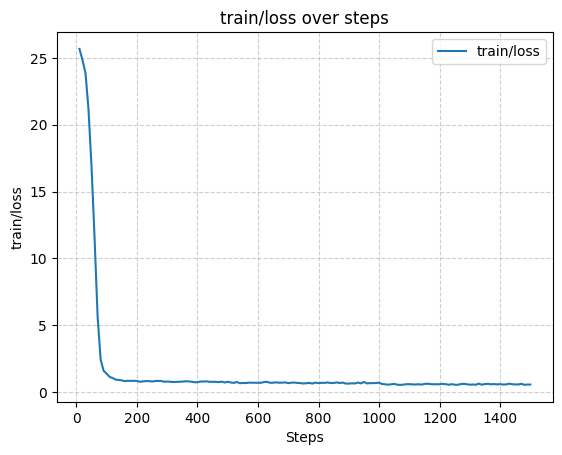

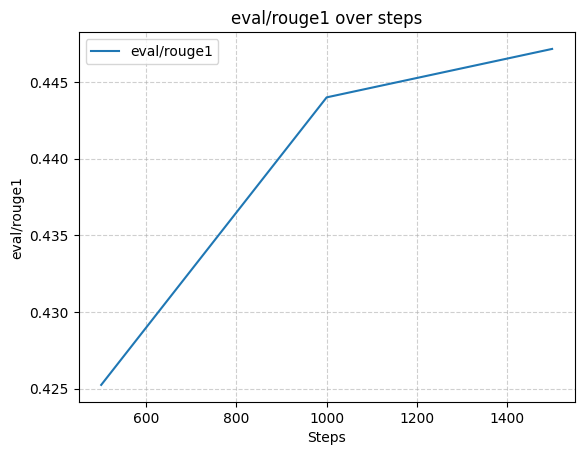

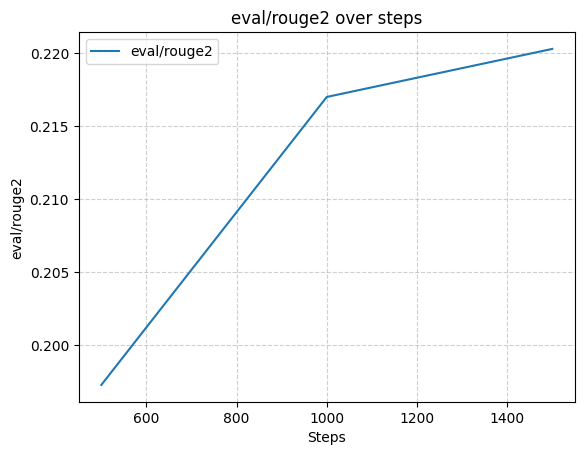

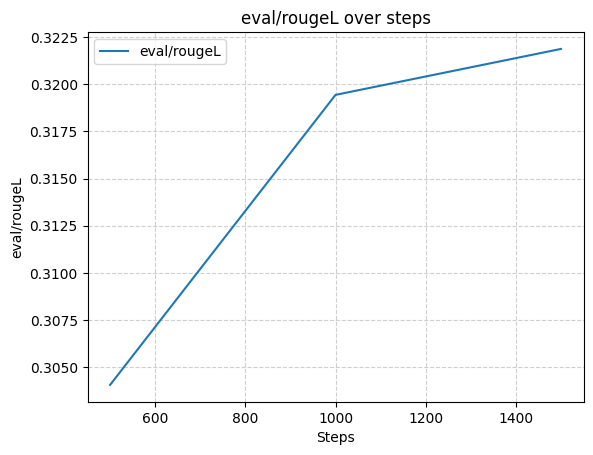

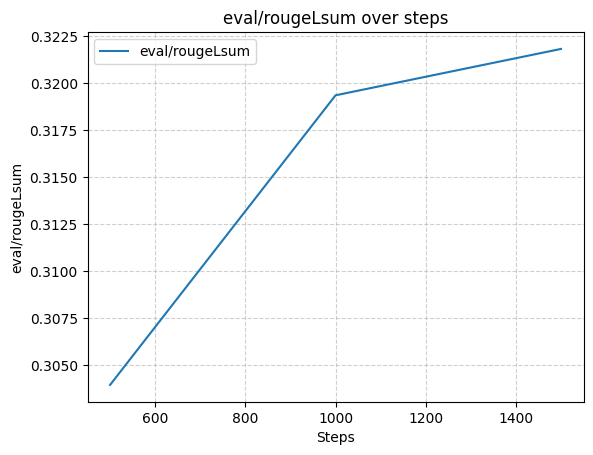

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = "./logs"
event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events")]

scalars = {}
for file in event_files:
    event_acc = EventAccumulator(file)
    event_acc.Reload()
    tags = event_acc.Tags()["scalars"]
    for tag in tags:
        events = event_acc.Scalars(tag)
        values = [event.value for event in events]
        steps = [event.step for event in events]
        if tag not in scalars:
            scalars[tag] = {"steps": steps, "values": values}
        else:
            scalars[tag]["steps"].extend(steps)
            scalars[tag]["values"].extend(values)

metrics_to_plot = ["train/loss", "eval/rouge1", "eval/rouge2", "eval/rougeL", "eval/rougeLsum"] # Các metrics thường dùng với transformers

for metric in metrics_to_plot:
    if metric in scalars:
        steps = scalars[metric]["steps"]
        values = scalars[metric]["values"]

        sorted_pairs = sorted(zip(steps, values))
        steps, values = zip(*sorted_pairs)
        
        plt.plot(steps, values, label=metric)
        plt.xlabel("Steps")
        plt.ylabel(metric)
        plt.title(f"{metric} over steps")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6) # Add gridlines for better readability
        plt.show()
    else:
        print(f"Metric {metric} not found in logs.")

In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# del pretrain_model
# del train_dataset
# del val_dataset
# del train_dataset_raw
# del val_dataset_raw
# del training_args
# del tokenizer
# del data_collator
# del trainer
# del device
# del rouge_metric

for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")

Number of GPUs available: 1
GPU 0: Tesla P100-PCIE-16GB
Memory Allocated: 2632.43 MB
Memory Cached: 3250.00 MB


In [22]:
input_text='Hội nghị về giải pháp và định hướng phát triển nghiên cứu ứng dụng tại Việt Nam đã được Bộ Y tế tổ chức hôm nay 6.12, tại Hà Nội. Tại hội nghị, TS Nguyễn Ngô Quang, Phó cục trưởng Cục Khoa học công nghệ và đào tạo (Bộ Y tế), cho biết tại Việt Nam, điều trị tế bào, đặc biệt là tế bào gốc còn mang tính tự phát, nhiều cơ sở y tế ứng dụng không đúng quy định. Đặc biệt, nhiều quảng cáo không được kiểm chứng khoa học, có thể gây hậu quả cho người hoặc hiệu quả không rõ ràng gây tốn kém. TS Nguyễn Ngô Quang khẳng định, ứng dụng trị liệu tế bào và sản phẩm từ tế bào được quản lý chặt chẽ mà vẫn khuyến khích được nghiên cứu TRẦN MINH "Nhiều người tại Việt Nam đã sang các quốc gia lân cận chi số tiền lớn cho trị liệu tế bào gốc. Chúng tôi cũng nghe nhiều người hỏi "các quốc gia khác đều điều trị tế bào gốc vô tư, thoải mái nhưng tại sao "quản" chặt chẽ thế?", ông Quang chia sẻ. Trả lời câu hỏi trên, Phó cục trưởng Cục Khoa học công nghệ và đào tạo cho biết: "Chúng tôi đã đến các quốc gia, làm việc với cơ quan quản lý và được biết, các quốc gia quản lý rất chặt chẽ, đảm bảo tính khoa học, chứ không thoải mái như nhiều người vẫn hiểu". Các nước như Nhật, Mỹ, hay châu Âu đều coi trị liệu tế bào là có nguy cơ cho người và đều chia cấp độ nguy cơ của trị liệu tế bào. Các cơ quan quản lý đều quy định đây là phương pháp mới, kỹ thuật mới, cần được Hội đồng Đạo đức nghiên cứu y sinh thẩm định, đánh giá để đưa ra các yêu cầu nghiên cứu. Quá trình nghiên cứu phải có đánh giá về an toàn, hiệu quả. Khi ứng dụng rồi vẫn cần đánh giá sau ứng dụng, để cơ quan quản lý xem xét chấp thuận tiếp tục triển khai hay dừng lại. "Chúng tôi đặc biệt quan tâm sản phẩm cuối cùng của công nghệ tế bào, về tính an toàn, hiệu quả", ông Quang nhấn mạnh. Chính phủ giao Bộ Y tế giám sát các nghiên cứu y sinh trên con người, đảm bảo quyền con người. Bộ Y tế đang trong giai đoạn hoàn thiện hệ thống văn bản pháp luật hoàn thiện quy định về nghiên cứu, thử nghiệm lâm sàng và ứng dụng các liệu pháp tế bào trong điều trị, chăm sóc sức khỏe người dân. Các quy định sẽ phải đảm bảo nguyên tắc khuyến khích phát triển khoa học công nghệ trong chăm sóc sức khỏe người dân nhưng không tự phát và phải an toàn, hiệu quả. Công nghệ mới được ứng dụng giúp người dân có được sức khỏe tốt hơn, hiệu quả hơn nhưng cần có hành lang pháp lý, đặc biệt là cần có minh chứng khoa học, hiệu quả. Với kinh nghiệm nhiều năm nghiên cứu về công nghệ tế bào, , GS Tạ Thành Văn, Chủ nhiệm Chương trình KC 10 quốc gia, cho hay các nước hiện vẫn tranh cãi về tế bào gốc, vì ứng dụng điều trị hiện cho hiệu quả khác nhau. Truyền tế bào gốc điều trị bệnh máu tại Viện Huyết học - truyền máu T.Ư CÔNG THẮNG Nguyên nhân, do chúng ta điều trị cá thể và hiệu quả điều trị phụ thuộc chất lượng tế bào của mỗi cá nhân. Ngoại trừ ghép tế bào gốc trong điều trị bệnh máu đã có hiệu quả rõ ràng. Thực tế đó cho thấy cần quy định pháp lý về trị liệu tế bào để không cản trở phát triển nhưng không lạm dụng, gây tốn kém. Đặc biệt, GS Văn cho rằng, cần làm rõ "tế bào gốc là sản phẩm hay quy trình kỹ thuật" để quản lý trong quá trình ứng dụng điều trị, chăm sóc sức khỏe. Tế bào gốc không phải là thuốc, nhưng quy trình kỹ thuật thì cũng không phải. Vì trong chừng mực nào đó, tế bào gốc là thuốc khi tạo ra sản phẩm tế bào truyền cho đồng loại. Còn trong trường hợp tách tế bào gốc của người để truyền lại cho chính cá thể đó, thì đó là quy trình. Trước thực tế việc phân định thuốc - quy trình kỹ thuật còn chưa phân định rõ với trị liệu tế bào, bao gồm ứng dụng tế bào gốc, GS Tạ Thành Văn lưu ý, là cần thiết. Trong nước, Bộ Y tế cần có tiêu chí về chất lượng khối tế bào, tế bào gốc và lập các labo tham chiếu, ngoại kiểm. Còn các đơn vị sản xuất tế bào trước hết phải công bố chất lượng, dựa trên tiêu chuẩn do Bộ Y tế ban hành.'

inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True).to(device)

outputs = pretrain_model.generate(
    inputs,
    max_new_tokens=256, 
    num_beams=4, 
    early_stopping=True,
    no_repeat_ngram_size=2
)

summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated Summary:")
print(summary)

Generated Summary:
Bộ Y tế đang trong giai đoạn hoàn thiện hệ thống văn bản pháp luật về nghiên cứu, thử nghiệm lâm sàng và ứng dụng trị liệu tế bào tại Việt Nam.
